# TimeCluster: dimension reduction applied to temporal data for visual analytics
https://link.springer.com/article/10.1007/s00371-019-01673-y

## Data
* https://www.renom.jp/ja/notebooks/tutorial/time_series/lstm-anomalydetection/notebook.html
* http://www.cs.ucr.edu/~eamonn/discords/

In [42]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [20]:
df = pd.read_csv("./data/qtdbsel102.txt", header=None, sep='\t')

# step1 - MinMaxScaler

In [21]:
df = df.apply(lambda x: (x - min(x))/(max(x)-min(x)), axis=0)

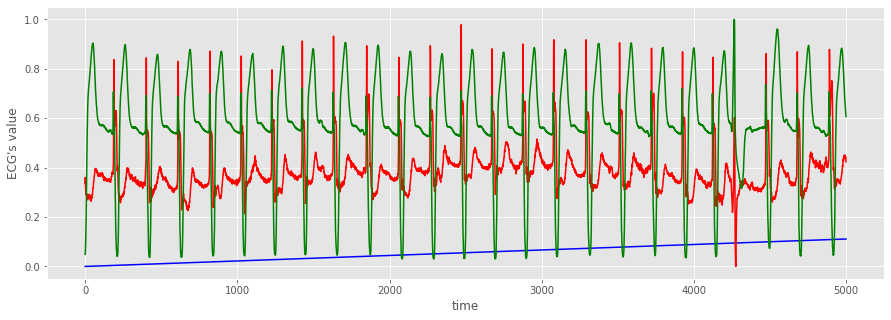

In [22]:
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('ECG\'s value')
plt.plot(np.arange(5000), df.iloc[:5000, 0], color='b')
plt.plot(np.arange(5000), df.iloc[:5000, 1], color='r')
plt.plot(np.arange(5000), df.iloc[:5000, 2], color='g')
plt.show()

In [25]:
df = df.values

# step2 - Sliding Window

In [37]:
w = 60
s = 1
t = 0
n_column = df.shape[1]
limit_r = int((len(df)-t-w+1)/s + 1)

In [40]:
%%time
period = []
SlideWindowDF = np.empty((w, n_column))
for r in range(1, limit_r):
    period.append(f'{t+(r-1)*s}~{t+(r-1)*s+w-1}')
    SlideWindowDF = np.dstack([SlideWindowDF, df[t+(r-1)*s: t+(r-1)*s+w]])

Wall time: 9min 11s


In [41]:
SlideWindowDF.shape

(60, 3, 44942)

In [43]:
with open("multi_SlideWindowDF.pkl", "wb") as f:
    pickle.dump(SlideWindowDF, f) #保存

In [47]:
'''
with open("multi_SlideWindowDF.pkl", "rb") as f:
    hoge = pickle.load(f) #読み出し
'''

'\nwith open("multi_SlideWindowDF.pkl", "rb") as f:\n    hoge = pickle.load(f) #読み出し\n'

# step5 - Deep convolutional auto-encoder DCAE

# step4 - Dimensionality Reduction(DR)

In [10]:
def scatter_plot(df):
    plt.scatter(df[:,0], df[:, 1])
    plt.show()

## PCA

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
PCA_DR = pca.fit_transform(SlideWindowDF)

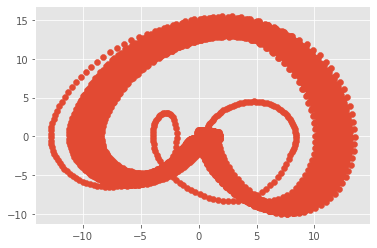

In [12]:
scatter_plot(PCA_DR)

## Kernel-PCA

In [13]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=2)
kPCA_DR = kpca.fit_transform(SlideWindowDF)

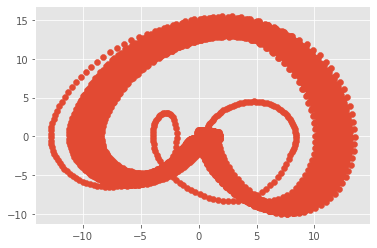

In [14]:
scatter_plot(kPCA_DR)

## t-SNE

In [15]:
from sklearn.manifold import TSNE

In [16]:
%%time
tSNE_DR = TSNE(n_components=2).fit_transform(SlideWindowDF)

Wall time: 5min 35s


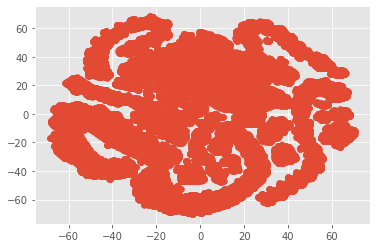

In [17]:
scatter_plot(tSNE_DR)

## UMAP
* https://arxiv.org/abs/1802.03426
* https://github.com/lmcinnes/umap

In [18]:
import umap

In [19]:
UMAP_DR = umap.UMAP().fit_transform(SlideWindowDF)

C:\Users\ail11208\Anaconda3\envs\brain\lib\site-packages\numba\typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\Anaconda3\envs\brain\lib\site-packages\umap\rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
C:\Users\ail11208\Anaconda3\envs\brain\lib\site-packages\numba\typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\Anaconda3\envs\brain\lib\site-packa

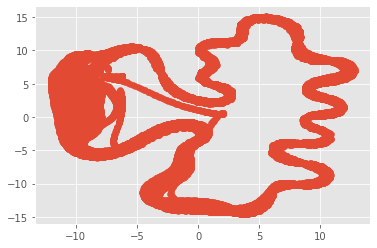

In [20]:
scatter_plot(UMAP_DR)

# K-Means

In [61]:
def label_scatter(df, n, y):
    #color = ['red', 'blue', 'yellow', 'green', 'black']
    for i in range(n):
        plt.scatter(df[y == i, 0], df[y == i, 1])
    plt.legend()
    plt.show()

In [62]:
from sklearn.cluster import KMeans

In [78]:
nc=30

In [79]:
kmeans = KMeans(n_clusters = nc, init = 'k-means++', random_state = 1)
y_kmeans = kmeans.fit_predict(PCA_DR)

No handles with labels found to put in legend.


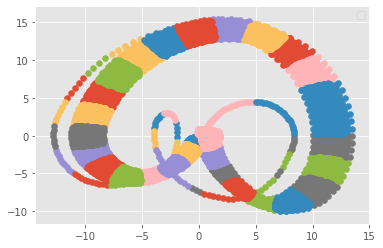

In [80]:
label_scatter(PCA_DR, nc, y_kmeans)

In [81]:
kmeans = KMeans(n_clusters = nc, init = 'k-means++', random_state = 1)
y_kmeans = kmeans.fit_predict(tSNE_DR)

No handles with labels found to put in legend.


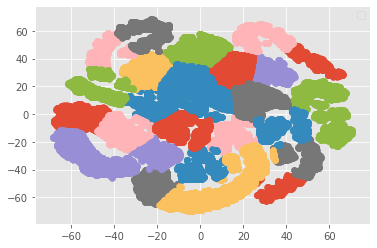

In [82]:
label_scatter(tSNE_DR, nc, y_kmeans)

# One-Class SVM

In [52]:
def outlier_plot(df, index):
    #====異常(外れ値)検知の結果====
    plt.scatter(df[:,0], df[:,1], c='blue')
    plt.scatter(df[index, 0], df[index, 1], c='red', label='outlair')
    plt.legend()
    #plt.savefig('OneClassSVM.png')
    plt.show()

In [53]:
from sklearn.svm import OneClassSVM

In [50]:
clf = OneClassSVM(nu=0.01, kernel="rbf", gamma=0.05)
clf.fit(PCA_DR)
pred = clf.predict(PCA_DR)

index = np.where(pred < 0)

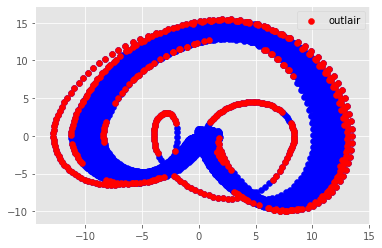

In [54]:
outlier_plot(PCA_DR, index)

In [57]:
clf = OneClassSVM(nu=0.01, kernel="rbf", gamma=0.01)
clf.fit(tSNE_DR)
pred = clf.predict(tSNE_DR)

index = np.where(pred < 0)

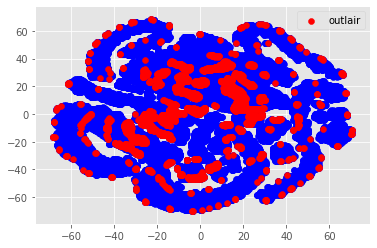

In [58]:
outlier_plot(tSNE_DR, index)